# Solving Schrodinger Equation with PINN

**Problem setup**  
  
We are going to solve the non-linear Schr√∂dinger equation given by  
$i h_t + \frac{1}{2} h_{xx} + |h|^2h = 0$  
  
with periodic boundary conditions as  
$x \in [-5,5], \quad t \in [0, \pi/2]$  
$h(t, -5) = h(t,5)$  
$h_x(t, -5) = h_x(t,5)$  
  
and initial condition equal to  
$h(0,x) = 2 sech(x)$



Deepxde only uses real numbers, so we need to explicitly split the real and imaginary parts of the complex PDE.  
  
In place of the single residual:

$f = ih_t + \frac{1}{2} h_{xx} +|h|^2 h$
  
we get the two (real valued) residuals:

$f_{\mathcal{R}} = u_t + \frac{1}{2} v_{xx} + (u^2 + v^2)v$  
$f_{\mathcal{I}} = v_t - \frac{1}{2} u_{xx} - (u^2 + v^2)u$  
  
where u(x,t) and v(x,t) denote respectively the real and the imaginary part of h.  


In [7]:
import brainstate as bst
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

import deepxde.experimental as deepxde

In [8]:
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi / 2

# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

# The whole domain flattened
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Space and time domains/geometry (for the experimental trainer)
space_domain = deepxde.geometry.Interval(x_lower, x_upper)
time_domain = deepxde.geometry.TimeDomain(t_lower, t_upper)
geomtime = deepxde.geometry.GeometryXTime(space_domain, time_domain)
geomtime = geomtime.to_dict_point('x', 't')

In [9]:
# The "physics-informed" part of the loss


def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    jacobian = net.jacobian(x)
    hessian = net.hessian(x)

    u = y['u']
    v = y['v']

    # In 'jacobian', i is the output component and j is the input component
    u_t = jacobian['u']['t']
    v_t = jacobian['v']['t']

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = hessian['u']['x']['x']
    v_xx = hessian['v']['x']['x']

    f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]

In [ ]:
# Network architecture
net = deepxde.nn.Model(
    deepxde.nn.DictToArray(x=None, t=None),
    deepxde.nn.FNN([2] + [100] * 4 + [2], "tanh"),
    deepxde.nn.ArrayToDict(u=None, v=None),
)

In [10]:
# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = deepxde.icbc.PeriodicBC('u', 'x', derivative_order=0, )
bc_u_1 = deepxde.icbc.PeriodicBC('u', 'x', derivative_order=1, )
bc_v_0 = deepxde.icbc.PeriodicBC('v', 't', derivative_order=0, )
bc_v_1 = deepxde.icbc.PeriodicBC('v', 't', derivative_order=1, )


# Initial conditions
def init_cond(x):
    "2 sech(x)"
    return {'u': 2 / u.math.cosh(x['x']), 'v': 0}


ic_u = deepxde.icbc.IC(init_cond)

In [11]:
data = deepxde.problem.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u],
    net,
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

In [ ]:
model = deepxde.Trainer(data)

Adam optimization.  

In [12]:
# To employ a GPU accelerated system is highly encouraged.
model.compile(bst.optim.Adam(1e-3), loss="MSE").train(iterations=10000, display_every=1000)

Compiling model...
'compile' took 0.004900 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [4.46e-01, 5.53e-01, 1.99e+00, 1.24e-02, 7.65e-01, 9.31e-04, 1.00e+00, 1.41e-01]    [4.46e-01, 5.53e-01, 1.99e+00, 1.24e-02, 7.65e-01, 9.31e-04, 1.00e+00, 1.41e-01]    []  
1000      [2.90e-03, 4.04e-03, 1.43e-05, 3.75e-04, 5.93e-06, 2.37e-06, 7.82e-03, 2.34e-03]    [2.90e-03, 4.04e-03, 1.43e-05, 3.75e-04, 5.93e-06, 2.37e-06, 7.82e-03, 2.34e-03]    []  
2000      [2.08e-03, 2.85e-03, 6.95e-06, 9.32e-05, 1.22e-06, 1.60e-06, 5.66e-03, 1.52e-03]    [2.08e-03, 2.85e-03, 6.95e-06, 9.32e-05, 1.22e-06, 1.60e-06, 5.66e-03, 1.52e-03]    []  
3000      [1.43e-03, 1.64e-03, 6.14e-06, 5.17e-05, 5.88e-07, 5.13e-07, 3.92e-03, 9.17e-04]    [1.43e-03, 1.64e-03, 6.14e-06, 5.17e-05, 5.88e-07, 5.13e-07, 3.92e-03, 9.17e-04]    []  
4000      [9.

(<pinnx._model.LossHistory at 0x21d91f695d0>,
 <pinnx._model.TrainState at 0x21d9222c250>)

L-BFGS optimization.

In [ ]:
model.compile(bst.optim.LBFGS(1e-3)).train(10000)

Compiling model...
'compile' took 0.972968 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
10000     [2.86e-04, 2.38e-04, 3.04e-06, 9.32e-06, 9.95e-06, 4.95e-07, 5.73e-04, 3.40e-04]    [2.86e-04, 2.38e-04, 3.04e-06, 9.32e-06, 9.95e-06, 4.95e-07, 5.73e-04, 3.40e-04]    []  
11000     [2.90e-04, 2.36e-04, 1.06e-06, 9.32e-06, 2.71e-07, 4.94e-07, 5.69e-04, 3.38e-04]    [2.90e-04, 2.36e-04, 1.06e-06, 9.32e-06, 2.71e-07, 4.94e-07, 5.69e-04, 3.38e-04]    []  
12000     [2.94e-04, 2.31e-04, 1.12e-06, 8.18e-06, 2.27e-07, 5.07e-07, 5.40e-04, 3.36e-04]    [2.94e-04, 2.31e-04, 1.12e-06, 8.18e-06, 2.27e-07, 5.07e-07, 5.40e-04, 3.36e-04]    []  


Final results.  
The reference solution and further information can be found in [this paper](https://arxiv.org/abs/1711.10561) from Raissi, Karniadakis, Perdikaris.  
The test data can be got [here](https://github.com/maziarraissi/PINNs/blob/master/main/Data/NLS.mat).

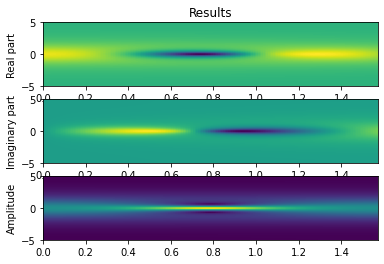

In [9]:
# Make prediction
prediction = model.predict({'x': X_star[:, 0], 't': X_star[:, 1]})

u = griddata(X_star, prediction['u'], (X, T), method="cubic")
v = griddata(X_star, prediction['v'], (X, T), method="cubic")

h = np.sqrt(u ** 2 + v ** 2)

# Plot predictions
fig, ax = plt.subplots(3)

ax[0].set_title("Results")
ax[0].set_ylabel("Real part")
ax[0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part")
ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude")
ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.show()

**Assess the accuracy**

We can employ the test data to assess the accuracy of the trained model.  
Using the normalized $L^2$ norm defined as  
  
Error $u$ = $\frac{1}{||u_{test}||_{L^2}} ||u_{test} - u_{pred}||_{L^2}$  
  
where $u_{test}$ is the reference solution and $u_{pred}$ is the prediction given by the model, we get:  
  
Error $u$: 1.854433e-03  
Error $v$: 2.413796e-03  
Error $h$: 1.426797e-03  
  
We can also plot the absolute value of the error for each point of the domain. It's everywhere in the order E-3.  






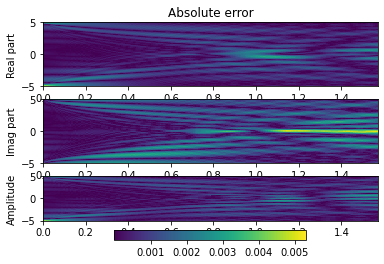